In [9]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as lin
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, fftfreq
import scipy.integrate
import time
plt.rc('font', size=12) 
import warnings
warnings.filterwarnings('ignore')

In [10]:
def wave_func(x, x_0, k_0, sig):
    """
    Construct a 1d array representing the wavefunction in space with given parameters
    
    :param x ndarray: A 1d array representing the discretization of our total space
    :param x_0 float: The average position of the wave packet
    :param k_0 float: The average wavenumber of the wave packet
    :param sig float: The spatial width (standard deviation) of the wave packet
    
    :return ndarray: A 1d array representing the wavefunction in space
    """
    
    # The constant numerator term
    c1 = np.exp(1j*k_0*x)
    # The constant denominator term
    c2 = ((2*np.pi)*((sig)**2))**0.25
    
    # The exponential term in x
    e = np.exp(-((x-x_0)**2)/(4*((sig)**2)))
    
    # combine the three terms
    phi = (c1/c2)*(e)

    return phi

def bar_energy(m, k_0, sig, h_bar):
    """
    Calculate the mean energy of the wavepacket. This will be the barrier height
    
    :param m float: The mass of the particle (set to 1 for the simulation)
    :param k_0 float: The average wavenumber of the wave packet
    :param sig float: The spatial width (standard deviation) of the wave packet
    :param h_bar float: Plancks constant divided by 2pi (set to 1 in this simulation)

    :return float: The mean energy of the particle (wavepacket)
    """
    
    E = 1.5*(h_bar**2)*(1 + 4*(k_0**2)*(sig**2))/(8*m*(sig**2))
    
    return E
    
def potential(Nx, dx, bar_width, bar_height):
    """
    Construct a 1d array representing the potential in space
    
    :param Nx int: The number of grid points into which our space is descretized
    :param dx float: The spatial separation between each grid point in space
    :param bar_width float: The width (spatial extent) of the potential barrier
    :param bar_height float: The height (energy) of the potential barrier 
    
    :return ndarray: A 1d array representing the potential barrier in space
    """
    
    # Define a potential array which extends our space. The potential will be 0 at all
    # points except for those within a region of width 'bar_width' about 0
    V = np.zeros(Nx)
    # Index Nx//2 represents the spatial position at x = 0. Here we want to create
    # a potential barrier that is centered about x=0 of width 'bar_width'
    # which is of width 'bar_width/2' on each side
    V[Nx//2 - int(bar_width/(2*dx)) : Nx//2 + int(bar_width//(2*dx))] = bar_height
    
    return V
    

def matrix_A(alpha, V, dt, h_bar):
    """
    Construct a Nx*Nx sparse matrix representing the first evolution matrix
    
    :param alpha float: A constant of the Crank-Nicolson evolution equation 
    :param V ndarray: A 1d array representing the potential barrier in space
    :param dt float: The time increment by which the system will be evolved on each iteration 
    :param h_bar float: Plancks constant divided by 2pi (set to 1 in this simulation)
    
    :return ndarray: A Nx*Nx sparse matrix representing the first evolution matrix
    """
        
    # Arrays to go in the Diagonal and off diagonal postitions of the evolution matrix A 
    A_diag = 2 + 2*alpha + 1j*dt*V/h_bar
    A_off_diag = -alpha
    # Create a sparse tridiagonal matrix 
    A = sp.diags([A_diag, A_off_diag, A_off_diag], [0, -1, 1])
    
    return A

def matrix_B(alpha, V, dt, h_bar):
    """
    Construct a Nx*Nx sparse matrix representing the second evolution matrix
    
    :param alpha float: A constant of the Crank-Nicolson evolution equation 
    :param V ndarray: A 1d array representing the potential barrier in space
    :param dt float: The time increment by which the system will be evolved on each iteration 
    :param h_bar float: Plancks constant divided by 2pi (set to 1 in this simulation)
    
    :return ndarray: A Nx*Nx sparse matrix representing the second evolution matrix
    """
        
    # Arrays to go in the Diagonal and off diagonal postitions of the evolution matrix B
    B_diag = 2 - 2*alpha - 1j*dt*V/h_bar
    B_off_diag = alpha

    # Create a sparse tridiagonal matrix 
    B = sp.diags([B_diag, B_off_diag, B_off_diag], [0, -1, 1])
    
    return B
    
def crank_matrix(A, B):
    """
    Construct a Nx*Nx sparse matrix representing the Crank-Nicolson matrix
    
    :param A ndarray: A Nx*Nx sparse matrix representing the first evolution matrix
    :param A ndarray: A Nx*Nx sparse matrix representing the second evolution matrix
    
    :return ndarray: A Nx*Nx sparse matrix representing the Crank-Nicolson evolution matrix
    """
    
    A_inv = lin.inv(A)
    C = A_inv@B

    return C


def evolve(phi_0, V, C, times, Nx, Nt):
    """
    Evolve the wavefuntion in time
    
    :param phi_0 ndarray: A 1d array representing the intitial wavefunction at time t = 0
    :param V ndarray: A 1d array representing the potential barrier in space
    :param C ndarray: A Nx*Nx sparse matrix representing the Crank-Nicolson evolution matrix
    :parm times ndarray: An array of time intervals at which we will store the wavepacket array
    """
    
    # The number of time intervals that we will save the wavefunction at
    n_times = len(times)

    # Each row represents the wavefunction at a different time. Hence, each row is a array of size Nx
    phi_arr = np.zeros(n_times*Nx, dtype = complex).reshape(n_times, Nx)
    
    phi = phi_0.copy()
    
    # j will be the index of time_arr, which will check whether we should save the wavepacket at a particular time
    j = 0
    # For each time iteration
    for i in range(Nt):
        # If the current time is one we wish to store, then store the wavepacket
        if i == times[j]:
            phi_arr[j] = phi
            j += 1
        
        # Evolve the wavepacket
        phi = C@phi
            
    phi_arr[-1] = phi
    
    return phi_arr 
    
def fourier(results, Nx, dx):
    """
    Calculate the fourier transform of every wavefunction (each at a different time) in the results array
    
    :param results ndarray: A d x Nx array where each row (d rows) represents the wavefunction at a different time
    :param Nx int: The total number of space points to represent our system
    :param dx float: The space separation between each of our points in space
    :return ft_norm ndarray: A d x Nx array where each row (d rows) represents the Fourier transform of the 
        wavefunction at a different time
    :return freq ndarray: The frequencies associated with the fourier transform
    """
    ft_shift = np.zeros_like(results, dtype = complex)
    ft_norm = np.zeros_like(results)

    
    for i in range(ft_shift.shape[0]):
        ft = fft(results[i])
        ft_shift[i] = 2*np.pi*fftshift(ft)
        
    # Normalise
    for i in range(ft_shift.shape[0]):
        ft_norm[i] = (ft_shift[i]*(ft_shift[i].conjugate()))/(scipy.integrate.simps(ft_shift[i]*(ft_shift[i].conjugate()), dx = 5e-2))

    
    n = np.arange(-Nx/2, Nx/2)
    freq = 2*np.pi*(n/(Nx*dx))
    
    return ft_norm, freq




def plot(results, ft, times, x, freq, bar_width):
    """
    Plot the wavefunction at each time shot and its associated fourier transform
    
    :param results ndarray: A d x Nx array where each row (d rows) represents the wavefunction at a different time
    :parm ft ndarray: A d x Nx array where each row (d rows) represents the Fourier transform of the 
        wavefunction at a different time
    :param times ndarray: A 1 x d array of the time values that each snapshot is taken
    :param x ndarray: A 1d array representing the discretization of our total space
    :parm freq ndarray: The frequencies associated with the fourier transform
    :param: bar_width float: The witdh of the potential barrier
    """
        
    n = len(times)
    fig, ax = plt.subplots(n, 2, figsize = (15, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    
    #fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
    
    for i in range(n):
        
        # Plot the wavefuntion 
        ax[i][0].plot(x, results[i]*results[i].conjugate(), color = 'black')#, label = f'$\phi(t = {times[i]})$')
        # Plot the barrier
        ax[i][0].axvline(x=-bar_width/2, color = 'black')#, label = 'Barrier')
        ax[i][0].axvline(x=bar_width/2, color = 'black')
        # If this iteration is not the last plot (as last plot is over a longer x-range)
        if i == (n-1):
            ax[i][0].set_xlim([-100, 100])
        else:
            ax[i][0].set_xlim([-30, 30])
        
        # Plot the fourier transforrm 
        ax[i][1].plot(freq, ft[i], color = 'black')#, label = f'$\phi(t = {times[i]})$')
        ax[i][1].set_xlim([-6, 6])
    
    size = 25
    
    fig.text(0.29, 0.08, '$x  (\mu m)$', ha = 'center', size = size)
    fig.text(0.74, 0.08, '$k  (1/\mu m)$', ha = 'center', size = size)
    fig.text(0.05, 0.5, '$|\Psi(x)|^2$', ha = 'center', rotation='vertical', size = size)
    fig.text(0.51, 0.5, '$|\Phi(k)|^2$', ha = 'center', rotation='vertical', size = size)
    
    # Uncomment to save the figure
    #plt.savefig(fname = 'results.png', format = 'png')
    
    plt.show()



In [11]:
# Run the simultion
def main():
    
    # Set necessary parameters

    # The total spatial extent of our simulation
    total_x = 400 #(in micrometers)
    # The total time extent of our simulation
    total_t = 25

    dx = 5e-2
    dt = 5e-3
    
    #dx = 1e-1
    #dt = 1e-2
    
    # Number of space points to represent our system. Total space extent of the system will be Nx*dx
    Nx = int(total_x/dx)      

    # Number of time points to represent our system. Total time extent of the system will be Nt*dt
    Nt = int(total_t/dt)    
    
    print(f'Nx = {Nx}')
    print(f'Nt = {Nt}')

    # Set system parameters for the simulation
    m  = 1          # Mass of the simulted particle. In this case an electron
    h_bar = 1       #  Planck's constant divided by 2pi
    k_0 = 2.0       # The average wavenumber of the wavepacket (given in paper)
    sig = 0.5       # The spatial width of the particle (given in paper)
    bar_width = 2   # Width of the potential barrier (given in question)

    x_0 = -10       # Average position of the wavepacket at time t = 0
    bar_height = bar_energy(m, k_0, sig, h_bar) # The height (energy) of the potentials non zero components

    # Simplified constant of the above parameters
    alpha = (1j*h_bar*dt)/((2*m*((dx)**2)))
    
    # Threshold is a constant value given in the paper which should be < 0.5 for the simulation to work smoothly
    print(f'Threshold = {h_bar*k_0*dt/(m*dx)}')

    # Spatial discretization 
    x = np.arange(-total_x//2, total_x//2, dx)
    
    #times = np.linspace(0, Nt, 5, dtype = int)
    times = np.array([0, 350, 800, Nt])
    #times = np.linspace(4000, Nt, 10, dtype = int)
    
    # Define the initial wavefunction 
    phi_0 = wave_func(x, x_0, k_0, sig)
    
    # Define the potential barrier
    V = potential(Nx, dx, bar_width, bar_height)
    
    # Define the Crank-Nicolson matrix
    A = matrix_A(alpha, V, dt, h_bar)
    B = matrix_B(alpha, V, dt, h_bar)
    C = crank_matrix(A, B)

    t_start = time.time()
        
    results = evolve(phi_0, V, C, times, Nx, Nt)
        
    t_end = time.time()
    print(f'Run time = {t_end - t_start} s')
    
    ft, freq = fourier(results, Nx, dx)
        
    
    plot(results, ft, times, x, freq, bar_width)
    
    return results, ft, times, x, freq, bar_width

Nx = 8000
Nt = 5000
Threshold = 0.19999999999999998
Run time = 87.86257529258728 s


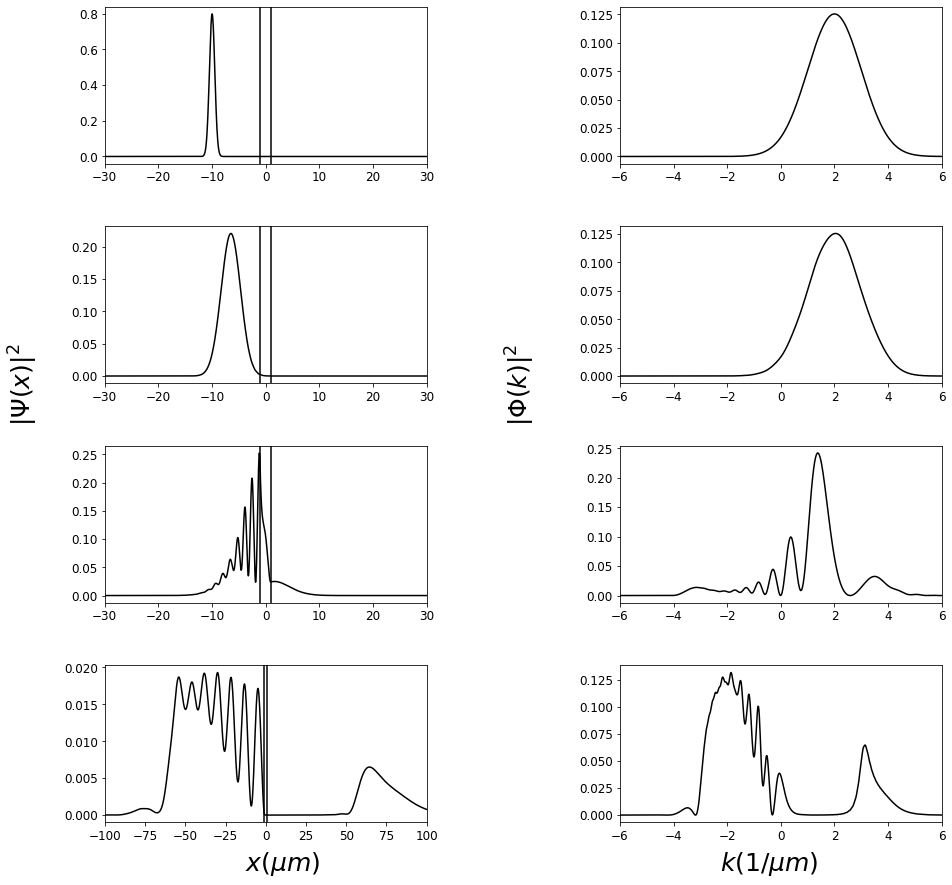

In [12]:
if __name__ == '__main__':
    results, ft, times, x, freq, bar_width = main()